In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import os
from pyspark.sql import functions as F

# DATA_DIR_L =  ""
# DATA_DIR = DATA_DIR_L

DATA_DIR_M = "/home/masa/Downloads/google-cloud-sdk/our_data"
DATA_DIR = DATA_DIR_M

In [2]:
# We use spark session in order to use DataFrames
ss = SparkSession.builder \
    .appName("GoogleClusterAnalysis") \
    .master("local[2]") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/02 13:31:06 WARN Utils: Your hostname, masa-VirtualBox, resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
26/01/02 13:31:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/02 13:31:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
ss.sparkContext.setLogLevel("ERROR")

### 1. What is the distribution of the machines according to their CPU capacity? Can you explain (motivate) it?

https://www.researchgate.net/publication/261164671_Characterizing_Machines_and_Workloads_on_a_Google_Cluster

TODO: add comments and conclusion

In [4]:
machine_schema = StructType([
    StructField('timestamp', LongType(), True),
    StructField('machine_ID', LongType(), True),
    StructField('event_type', IntegerType(), True),
    StructField('platform_ID', StringType(), False),
    StructField('CPUs', DoubleType(), False),
    StructField('memory_capacity', DoubleType(), False),
    ])

In [5]:
df_machines = ss.read.csv(os.path.join(DATA_DIR,"machine_events/*.csv.gz"), schema=machine_schema)
df_machines.show(5)

[Stage 0:>                                                          (0 + 1) / 1]

+---------+----------+----------+--------------------+----+---------------+
|timestamp|machine_ID|event_type|         platform_ID|CPUs|memory_capacity|
+---------+----------+----------+--------------------+----+---------------+
|        0|         5|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|
|        0|         6|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|
|        0|         7|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|
|        0|        10|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|
|        0|        13|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|
+---------+----------+----------+--------------------+----+---------------+
only showing top 5 rows


In [6]:
df_machines.select('machine_ID').distinct().count()

12583

In [7]:
df_machines.select("event_type").distinct().count()

3

In [8]:
df_machines.filter(df_machines["event_type"] == 0).distinct().count()

21443

In [9]:
total_count_t0 = df_machines.filter(df_machines["timestamp"] == 0).distinct().count()
total_count_t0

12477

In [10]:
df_machines.select("machine_ID").filter(df_machines["timestamp"] == 0).distinct().count()

12477

In [11]:
df_machines.select("CPUs").filter(df_machines["timestamp"] == 0).distinct().show()

+----+
|CPUs|
+----+
| 1.0|
| 0.5|
|0.25|
+----+



In [12]:
df_ex1 = df_machines.select(['machine_ID', 'CPUs']).filter(df_machines["timestamp"] == 0).groupby('CPUs').count()
df_ex1.show()

+----+-----+
|CPUs|count|
+----+-----+
| 1.0|  791|
| 0.5|11563|
|0.25|  123|
+----+-----+



In [13]:
df_ex1.withColumn("percentage", F.round((F.col("count") / total_count_t0) * 100)).show()

+----+-----+----------+
|CPUs|count|percentage|
+----+-----+----------+
| 1.0|  791|       6.0|
| 0.5|11563|      93.0|
|0.25|  123|       1.0|
+----+-----+----------+



- at timestamp==0, there are 12477 machines intially started, and for them we want to  find the distribution (of those machines) acoording to their CPU capacity

### 2. What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)? The computational power is proportional to both the CPU capacity and the unavailabil- ity period of machines.

- event_type = 1 means that a machine was removed from the cluster. Removals can occur due to
failures or maintenance
- we want to find all the times machien was removed due to maintenance and then reconnected later (event_type=0 in a time step later than for the event_type=1)

In [14]:
from pyspark.sql import Window

In [15]:
window = Window.partitionBy("machine_ID").orderBy("timestamp")

df_next = df_machines.withColumn("next_event", F.lead("event_type").over(window))
df_next = df_next.withColumn("next_time", F.lead("timestamp").over(window))

df_next.show(5)

+------------+----------+----------+--------------------+----+---------------+----------+------------+
|   timestamp|machine_ID|event_type|         platform_ID|CPUs|memory_capacity|next_event|   next_time|
+------------+----------+----------+--------------------+----+---------------+----------+------------+
|           0|         5|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         1|835150655707|
|835150655707|         5|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|836124903464|
|836124903464|         5|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|      NULL|        NULL|
|           0|         6|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|      NULL|        NULL|
|           0|         7|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|      NULL|        NULL|
+------------+----------+----------+--------------------+----+---------------+----------+------------+
only showing top 5 rows


- By partitioning the window by machine_id, we ensure that all events types are processed independently for **each machine**. In that way, we are sure that event pairings will refer to the same physical machine

- The lead() function returns the following event and time for the same machine. Previously, we ordered events by timestamp, and therefore, "next" refers to the next chronological event in that machine's sequence of events. In that way, we can be sure that we are identifying distinct offline intervals without overlappings

In [16]:
# this is just a check to see if time intervals are not overlapping, and if event types are matching
df_next.filter(df_next["machine_ID"] == 43).show(5)

+------------+----------+----------+--------------------+----+---------------+----------+------------+
|   timestamp|machine_ID|event_type|         platform_ID|CPUs|memory_capacity|next_event|   next_time|
+------------+----------+----------+--------------------+----+---------------+----------+------------+
|           0|        43|         0|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         2|372991930737|
|372991930737|        43|         2|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         2|373198072841|
|373198072841|        43|         2|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         2|727861243083|
|727861243083|        43|         2|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         2|736148630106|
|736148630106|        43|         2|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         2|736768939531|
+------------+----------+----------+--------------------+----+---------------+----------+------------+
only showing top 5 rows


- Now, we want to filter df_next to reflect only situations when machine went offline and was reloaded afterwards. That can be achieved by observing **event_type=1** followed by **next_event=0**

In [17]:
df_reloaded = df_next.filter((df_next["event_type"]==1) & (df_next["next_event"]==0))
df_reloaded.count()

8860

- We notice that this number matches the number of such observed cases of reloaded machines that were mentioned in paper: https://www.researchgate.net/publication/261164671_Characterizing_Machines_and_Workloads_on_a_Google_Cluster  on page 3 (Figure 3) which tells us we're on good trace

In [18]:
# Here we just extract offline time in a column named "dtime"
df_reloaded = df_reloaded.withColumn("dtime", F.col("next_time").cast("long")-F.col("timestamp").cast("long")).drop("timestamp", "next_time")
df_reloaded.show(5)

+----------+----------+--------------------+----+---------------+----------+-----------+
|machine_ID|event_type|         platform_ID|CPUs|memory_capacity|next_event|      dtime|
+----------+----------+--------------------+----+---------------+----------+-----------+
|         5|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|  974247757|
|        10|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|  998726348|
|        13|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|  997280215|
|        23|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|  120851153|
|        26|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|88666880740|
+----------+----------+--------------------+----+---------------+----------+-----------+
only showing top 5 rows


In [19]:
# Now we want to calculate lost resources for each sample as a product of offline time and CPUs, and then we sum over all samples
df_reloaded = df_reloaded.withColumn("lost", df_reloaded["dtime"]*df_reloaded["CPUs"])
total_lost = df_reloaded.agg(F.sum("lost")).collect()[0][0]
total_lost

80273246292457.75

In [20]:
# Now, in order to find percentage of lost resources, we want to find possible total power
total_cpu = df_machines.select("machine_ID", "CPUs").agg(F.sum("CPUs")).collect()[0]["sum(CPUs)"]
trace_bounds = df_machines.agg(
    F.min("timestamp").alias("start"),
    F.max("timestamp").alias("end")
).collect()[0]
total_time = trace_bounds["end"] - trace_bounds["start"]

total_power = total_cpu * total_time

In [21]:
percentage_lost = total_lost/total_power * 100
print(f"Percentage of computational power lost due to maintenance: {percentage_lost:.4f}%")

Percentage of computational power lost due to maintenance: 0.1613%


**Here, we conclude that the total percentage of computational power lost due to mainenance is 0.16%**

In [22]:
# maybe we need it for later, if not - delete :))

# machine_att_schema = StructType([
#     StructField('timestamp', LongType(), True),
#     StructField('machine_ID', LongType(), True),
#     StructField('attribute_name:', StringType(), True),
#     StructField('attribute_value', StringType(), False),
#     StructField('attribute_deleted:', BooleanType(), False),
#     ])

# df_machine_attributes = ss.read.csv(os.path.join(DATA_DIR,"machine_attributes/*.csv.gz"), schema=machine_att_schema)
# df_machine_attributes.show(5)

### 3. Is there a class of machines, according to their CPU, that stands out with a higher maintenance rate, as compared to other classes ?

- Here, by maintenance rate, we observe how frequently machines undergo maintenance (such as offline periods). We want to see if there is a class of machines (grouped by their CPU capacity) that experiences longer or more frequent maintenance periods compared to others

In [23]:
# Here, we check if every distinct machine can take only one value of CPU 
dfff = df_machines.groupBy("machine_ID").agg(F.count_distinct("CPUs").alias("distinct_cpus"))
dfff.filter(F.col("distinct_cpus") > 1).show()
# We conclude that only one CPUs value can be taken by one machine

+----------+-------------+
|machine_ID|distinct_cpus|
+----------+-------------+
+----------+-------------+



In [24]:
# We will calculate maintenance rate as a total_offline_time per machine divided by total_time (already calculated). 
# We will use already calculated df_reloaded from previous task
df_reloaded.show(5)

+----------+----------+--------------------+----+---------------+----------+-----------+--------------+
|machine_ID|event_type|         platform_ID|CPUs|memory_capacity|next_event|      dtime|          lost|
+----------+----------+--------------------+----+---------------+----------+-----------+--------------+
|         5|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|  974247757| 4.871238785E8|
|        10|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|  998726348|  4.99363174E8|
|        13|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|  997280215| 4.986401075E8|
|        23|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|  120851153|  6.04255765E7|
|        26|         1|HofLGzk1Or/8Ildj2...| 0.5|         0.2493|         0|88666880740|4.433344037E10|
+----------+----------+--------------------+----+---------------+----------+-----------+--------------+
only showing top 5 rows


In [25]:
df_reloaded.count()

8860

In [26]:
df_offline_times = df_reloaded.groupBy("machine_ID", "CPUs").agg(F.sum("dtime").alias("total_offline_time"))
df_offline_times.show(5)

+----------+----+------------------+
|machine_ID|CPUs|total_offline_time|
+----------+----+------------------+
|         5| 0.5|         974247757|
|        10| 0.5|         998726348|
|        13| 0.5|         997280215|
|        23| 0.5|         120851153|
|        26| 0.5|       88666880740|
+----------+----+------------------+
only showing top 5 rows


In [27]:
df_offline_times = df_offline_times.withColumn(
    "maintenance_rate_percentage", 
    F.col("total_offline_time").cast("double") * 100 / total_time)
df_offline_times.show(5)

+----------+----+------------------+---------------------------+
|machine_ID|CPUs|total_offline_time|maintenance_rate_percentage|
+----------+----+------------------+---------------------------+
|         5| 0.5|         974247757|       0.038874504571689526|
|        10| 0.5|         998726348|       0.039851251082934525|
|        13| 0.5|         997280215|        0.03979354737921456|
|        23| 0.5|         120851153|       0.004822211461137036|
|        26| 0.5|       88666880740|         3.5379922980767815|
+----------+----+------------------+---------------------------+
only showing top 5 rows


In [28]:
df_offline_times.groupBy("CPUs").agg(F.avg("maintenance_rate_percentage")).show()

+----+--------------------------------+
|CPUs|avg(maintenance_rate_percentage)|
+----+--------------------------------+
| 1.0|              0.7976476440387422|
| 0.5|              1.2378912755606144|
|0.25|              1.9150004966013052|
+----+--------------------------------+



**From here, we conclude that machines with lowest CPU capacity (0.25) have the highest average maintenance rate (~1.92%)** <br>
 Therefore, the conclusion is that lower-CPU machines tend to have higher maintenance rates, which means they either undergo maintenance more frequently or for longer periods.


### 4. What is the distribution of the number of jobs/tasks per scheduling class? Comment on the results.

Tasks and jobs can be resubmitted multiple times if they fail, therefore unique tasks are identified by their key (job_id) or composite key (job_id, task_index) and filtered with ".distinct()" to ensure each task is counted only once, regardless of how many lifecycle events it generated.

In [29]:
# Define schema for job events table
job_events_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user_name", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("job_name", StringType(), True),
    StructField("logical_job_name", StringType(), True)
])

In [30]:
df_job_events = ss.read.csv(os.path.join(DATA_DIR,"job_events/*.csv.gz"), schema=job_events_schema)
df_job_events.show(5)

+------------+------------+----------+----------+--------------------+----------------+--------------------+--------------------+
|   timestamp|missing_info|    job_id|event_type|           user_name|scheduling_class|            job_name|    logical_job_name|
+------------+------------+----------+----------+--------------------+----------------+--------------------+--------------------+
|772325004610|        NULL|6319958772|         1|ZpQmujQYX55FcN2RF...|               0|4iFTcCfph6IhTG3o4...|AmKr63lD9MIGXiAac...|
|772325045338|        NULL|6319984350|         0|E+9U+J1Dicd5PJklb...|               1|UaXnrc6huaDo9qNtX...|Mz+7hmVdCFVQEwwuv...|
|772325074372|        NULL|6319983180|         0|r/Al6kYJOwZITr6wi...|               2|ct6ai8SyqLEEEdgBS...|G/9E4AW9fSviXbmdF...|
|772326178083|        NULL|6319984385|         0|F2+Gv53Pxd4KDRb/U...|               0|aPxb6dFdH8wZ2FTBC...|j25eTfDZ4FFHzd7p+...|
|772327671789|        NULL|6319983180|         1|r/Al6kYJOwZITr6wi...|               2|ct6

In [31]:
# define schema for task events table
task_events_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user_name", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("req_cpu_cores", DoubleType(), True),
    StructField("req_ram", DoubleType(), True),
    StructField("req_local_disk", DoubleType(), True),
    StructField("different_machine_constraint", BooleanType(), True)
])

In [32]:
df_task_events = ss.read.csv(os.path.join(DATA_DIR,"task_events/*.csv.gz"), schema=task_events_schema)
df_task_events.show(5)

+------------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-------------+-------+--------------+----------------------------+
|   timestamp|missing_info|    job_id|task_index|machine_id|event_type|           user_name|scheduling_class|priority|req_cpu_cores|req_ram|req_local_disk|different_machine_constraint|
+------------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-------------+-------+--------------+----------------------------+
|767314028182|        NULL| 515042969|        15| 257406228|         1|/fk1fVcVxZ6iM6gHZ...|               2|       0|      0.01562|0.01553|      2.155E-4|                        NULL|
|767314057755|        NULL|6319230508|        13|   6567628|         4|r/Al6kYJOwZITr6wi...|               0|       4|      0.06873|0.00795|      3.815E-5|                        NULL|
|767314057799|        NULL|6319230508|         3|    902367|         4|r/Al

In [33]:
# Count number of unique jobs per scheduling class
# groupBy creates groups based on scheduling_class
# agg with count counts the number of job_ids in each group
jobs_per_class = df_job_events.select("job_id", "scheduling_class").distinct().groupBy("scheduling_class").agg(F.count("job_id").alias("num_of_jobs"))

jobs_per_class.show()

+----------------+-----------+
|scheduling_class|num_of_jobs|
+----------------+-----------+
|               1|       2977|
|               3|        110|
|               2|       2525|
|               0|       3158|
+----------------+-----------+



In [34]:
# Calculate total number of unique jobs in the dataset
# counts distinct job_ids across all events to get the absolute total
total_jobs = df_job_events.select("job_id").distinct().count()
total_jobs

8770

In [35]:
# verify total_jobs
2977 + 110 + 2525 + 3158

8770

In [36]:
jobs_per_class.withColumn("percentage", F.round((F.col("num_of_jobs") / total_jobs) * 100)).show()

+----------------+-----------+----------+
|scheduling_class|num_of_jobs|percentage|
+----------------+-----------+----------+
|               1|       2977|      34.0|
|               3|        110|       1.0|
|               2|       2525|      29.0|
|               0|       3158|      36.0|
+----------------+-----------+----------+



In [37]:
# Count number of unique tasks per scheduling class
# groupBy creates groups based on scheduling_class
# agg with count counts the number of job_ids in combination with task_index in each group
tasks_per_class = df_task_events.select("job_id", "task_index", "scheduling_class").distinct().groupBy("scheduling_class").agg(F.count("*").alias("num_of_tasks"))

tasks_per_class.show()

[Stage 114:============================>                            (1 + 1) / 2]

+----------------+------------+
|scheduling_class|num_of_tasks|
+----------------+------------+
|               1|       32864|
|               3|        2590|
|               2|        9607|
|               0|      285756|
+----------------+------------+



In [38]:
# Calculate total number of unique jobs in the dataset
# counts distinct combination of job_ids and task_index across all events to get the absolute total
total_tasks = df_task_events.select("job_id", "task_index").distinct().count()
total_tasks

330817

In [39]:
tasks_per_class.withColumn("percentage", F.round((F.col("num_of_tasks") / total_tasks) * 100)).show()

[Stage 126:============================>                            (1 + 1) / 2]

+----------------+------------+----------+
|scheduling_class|num_of_tasks|percentage|
+----------------+------------+----------+
|               1|       32864|      10.0|
|               3|        2590|       1.0|
|               2|        9607|       3.0|
|               0|      285756|      86.0|
+----------------+------------+----------+



Analysis based on 9098 jobs that had at least one task scheduled (event_type=1) in the task_events table.

**Scheduling Class Distribution:**
- Class 0 (non-production): ~35% of jobs and 86% of task, this suggests non-production jobs tend to have many tasks per job
- Class 1: 34% of jobs, 10% of tasks
- Class 2: 29% of jobs, 3% of tasks  
- Class 3 (most latency-sensitive): Only 1% of both jobs and tasks, indicating production workloads are a small but critical portion of the cluster

**->** Non-production workloads (class 0) dominate task count and job count, suggesting they involve large-scale data processing jobs with many parallel tasks while, as the "Google documentation" notes, class 3 represents more latency-senstive tasks in production, being potentially short-lived and fast.

### 5. Would you qualify the percentage of jobs/tasks that got killed or evicted as important? 

In [40]:
# Define event type constants for readability
EVICT = 2
KILL = 5

# Count unique jobs that were killed or evicted at least once across its lifecycle
jobs_killed_evicted = df_job_events.filter(F.col("event_type").isin([EVICT, KILL])).select("job_id").distinct().count()

# Calculate percentage
perc_jobs_killed_evicted = round(jobs_killed_evicted / total_jobs * 100)
perc_jobs_killed_evicted

46

In [41]:
# Break down by event type "KILL"
jobs_killed = df_job_events.filter(F.col("event_type") == KILL).select("job_id").count()
jobs_killed

3997

In [42]:
# Break down by event type "EVICT"
jobs_evicted = df_job_events.filter(F.col("event_type") == EVICT).select("job_id").count()
jobs_evicted

0

In [43]:
# Count unique tasks that were killed or evicted at least once across its lifecycle
tasks_killed_evicted = df_task_events.filter(F.col("event_type").isin([EVICT, KILL])).select("task_index", "job_id").distinct().count()

# Calculate percentage
perc_tasks_killed_evicted = round(tasks_killed_evicted / total_tasks * 100)
perc_tasks_killed_evicted

43

In [44]:
# Break down by event type "KILL"
tasks_killed = df_task_events.filter(F.col("event_type")== KILL).select("task_index").count()
tasks_killed

138951

In [45]:
# Break down by event type "EVICT"
tasks_evicted = df_task_events.filter(F.col("event_type")== EVICT).select("task_index").count()
tasks_evicted

83227

### 6. Do tasks with a low scheduling class have a higher probability of being evicted?

In [46]:
# visual check of df
df_task_events.show(5)

+------------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-------------+-------+--------------+----------------------------+
|   timestamp|missing_info|    job_id|task_index|machine_id|event_type|           user_name|scheduling_class|priority|req_cpu_cores|req_ram|req_local_disk|different_machine_constraint|
+------------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-------------+-------+--------------+----------------------------+
|767314028182|        NULL| 515042969|        15| 257406228|         1|/fk1fVcVxZ6iM6gHZ...|               2|       0|      0.01562|0.01553|      2.155E-4|                        NULL|
|767314057755|        NULL|6319230508|        13|   6567628|         4|r/Al6kYJOwZITr6wi...|               0|       4|      0.06873|0.00795|      3.815E-5|                        NULL|
|767314057799|        NULL|6319230508|         3|    902367|         4|r/Al

In [47]:
# filter df for evicted tasks 
df_tasks_evicted = df_task_events.filter(F.col("event_type") == EVICT).select("task_index", "scheduling_class")
df_tasks_evicted.show()

+----------+----------------+
|task_index|scheduling_class|
+----------+----------------+
|       101|               0|
|       118|               0|
|      1367|               0|
|       432|               0|
|       463|               1|
|       505|               0|
|        26|               0|
|      2875|               1|
|      4582|               0|
|       155|               0|
|        14|               0|
|      1765|               1|
|       407|               0|
|       343|               2|
|        11|               3|
|        98|               0|
|      1958|               1|
|       189|               0|
|      2020|               0|
|      1139|               0|
+----------+----------------+
only showing top 20 rows


In [48]:
# group evicted tasks by scheduling class and count them
df_tasks_evicted_count = df_tasks_evicted.groupBy("scheduling_class").count()
df_tasks_evicted_count.show()

[Stage 158:============================>                            (1 + 1) / 2]

+----------------+-----+
|scheduling_class|count|
+----------------+-----+
|               1|17086|
|               3|  873|
|               2| 3253|
|               0|62015|
+----------------+-----+



In [49]:
# calculate percentage
df_tasks_evicted_count.withColumn("percentage", F.round((F.col("count") / tasks_evicted) * 100)).show()

[Stage 161:============================>                            (1 + 1) / 2]

+----------------+-----+----------+
|scheduling_class|count|percentage|
+----------------+-----+----------+
|               1|17086|      21.0|
|               3|  873|       1.0|
|               2| 3253|       4.0|
|               0|62015|      75.0|
+----------------+-----+----------+



Yes, tasks with a lower scheduling class are evicted more often than tasks with a higher scheduling class.

### 7. In general, do tasks from the same job run on the same machine? Comment on the observed locality strategy and its pros and cons.

In [50]:
# visual check of df
df_task_events.show(5)

+------------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-------------+-------+--------------+----------------------------+
|   timestamp|missing_info|    job_id|task_index|machine_id|event_type|           user_name|scheduling_class|priority|req_cpu_cores|req_ram|req_local_disk|different_machine_constraint|
+------------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-------------+-------+--------------+----------------------------+
|767314028182|        NULL| 515042969|        15| 257406228|         1|/fk1fVcVxZ6iM6gHZ...|               2|       0|      0.01562|0.01553|      2.155E-4|                        NULL|
|767314057755|        NULL|6319230508|        13|   6567628|         4|r/Al6kYJOwZITr6wi...|               0|       4|      0.06873|0.00795|      3.815E-5|                        NULL|
|767314057799|        NULL|6319230508|         3|    902367|         4|r/Al

In [51]:
# filtering for scheduled tasks
df_scheduled = df_task_events.filter(F.col("event_type") == 1)

In [52]:
# for each job count number of unique tasks and number of unique machines used

df_jobs_machines = df_scheduled.groupBy("job_ID").agg(
    F.countDistinct("task_index").alias("num_of_tasks"),
    F.countDistinct("machine_ID").alias("num_of_machines")
)

df_jobs_machines.show()

[Stage 165:============================>                            (1 + 1) / 2]

+----------+------------+---------------+
|    job_ID|num_of_tasks|num_of_machines|
+----------+------------+---------------+
|6318966074|         652|            868|
|6319490931|         450|            437|
|6319448540|         250|            269|
|6051350394|           1|              3|
|6320614703|          50|             50|
|6320107735|          11|             11|
|6320448576|           1|              1|
|5554591681|           1|              4|
|6319623988|           1|              1|
|6319329039|           1|              1|
|6320352830|           1|              1|
|6319915253|           2|              3|
|6320361453|           1|              1|
|6320271861|           1|              1|
|6319988764|           1|              1|
|6320088748|           1|              1|
|6319578798|           1|              1|
|6320267112|           1|              1|
|6318906123|         180|            181|
|6318971380|           1|              1|
+----------+------------+---------

In [53]:
tasks_per_machine = df_jobs_machines.withColumn("tasks_per_machine", F.col("num_of_tasks") / F.col("num_of_machines"))
tasks_per_machine.show()

[Stage 171:============================>                            (1 + 1) / 2]

+----------+------------+---------------+------------------+
|    job_ID|num_of_tasks|num_of_machines| tasks_per_machine|
+----------+------------+---------------+------------------+
|6318966074|         652|            868|0.7511520737327189|
|6319490931|         450|            437|1.0297482837528604|
|6319448540|         250|            269| 0.929368029739777|
|6051350394|           1|              3|0.3333333333333333|
|6320614703|          50|             50|               1.0|
|6320107735|          11|             11|               1.0|
|6320448576|           1|              1|               1.0|
|5554591681|           1|              4|              0.25|
|6319623988|           1|              1|               1.0|
|6319329039|           1|              1|               1.0|
|6320352830|           1|              1|               1.0|
|6319915253|           2|              3|0.6666666666666666|
|6320361453|           1|              1|               1.0|
|6320271861|           1

In [54]:
task_per_machine = tasks_per_machine.withColumn(
    "category",
    F.when(F.col("num_of_machines") == 1, "all_on_one") # all task of jobs run on the same machine
     .when(F.col("tasks_per_machine") > 1, "multiple_tasks_per_machine")
     .when(F.col("tasks_per_machine") == 1, "fully_distributed") # 1 task per machine 
     .when(F.col("tasks_per_machine") < 1, "over_distributed") # more machines than tasks
     .otherwise("?")
)
task_per_machine.show()

[Stage 177:============================>                            (1 + 1) / 2]

+----------+------------+---------------+------------------+--------------------+
|    job_ID|num_of_tasks|num_of_machines| tasks_per_machine|            category|
+----------+------------+---------------+------------------+--------------------+
|6318966074|         652|            868|0.7511520737327189|    over_distributed|
|6319490931|         450|            437|1.0297482837528604|multiple_tasks_pe...|
|6319448540|         250|            269| 0.929368029739777|    over_distributed|
|6051350394|           1|              3|0.3333333333333333|    over_distributed|
|6320614703|          50|             50|               1.0|   fully_distributed|
|6320107735|          11|             11|               1.0|   fully_distributed|
|6320448576|           1|              1|               1.0|          all_on_one|
|5554591681|           1|              4|              0.25|    over_distributed|
|6319623988|           1|              1|               1.0|          all_on_one|
|6319329039|    

In [55]:
category_counts = task_per_machine.groupBy("category").agg(F.count("*").alias("num_of_jobs"))
category_counts.show()

[Stage 183:============================>                            (1 + 1) / 2]

+--------------------+-----------+
|            category|num_of_jobs|
+--------------------+-----------+
|          all_on_one|       6125|
|    over_distributed|        980|
|multiple_tasks_pe...|        151|
|   fully_distributed|       1842|
+--------------------+-----------+



In [56]:
total_jobs = task_per_machine.select("job_id").distinct().count()
total_jobs

9098

In [57]:
# verifying the total_jobs
total_jobs_2 = df_jobs_machines.select("job_id").distinct().count()
total_jobs_2

9098

In [58]:
# verifying the total_jobs
6125 + 980 + 151 + 1842

9098

In [59]:
# calculate percentage
category_counts.withColumn("percentage", F.round((F.col("num_of_jobs") / total_jobs) * 100)).show()

[Stage 205:============================>                            (1 + 1) / 2]

+--------------------+-----------+----------+
|            category|num_of_jobs|percentage|
+--------------------+-----------+----------+
|          all_on_one|       6125|      67.0|
|    over_distributed|        980|      11.0|
|multiple_tasks_pe...|        151|       2.0|
|   fully_distributed|       1842|      20.0|
+--------------------+-----------+----------+



As the category "all_on_one" contains single-task jobs (num_tasks = 1), which trivially run on one machine only, since there's only one task to place, the analysis is restructured to multi-task-jobs only.

In [60]:
multi_task_jobs = task_per_machine.filter(F.col("num_of_tasks") > 1)
total_multi = multi_task_jobs.count()
total_multi

2500

In [61]:
df_multi_task = multi_task_jobs.groupBy("category").agg(
    F.count("*").alias("num_of_jobs")
).withColumn(
    "percentage",
    F.round((F.col("num_of_jobs") / total_multi * 100), 1)
)

In [62]:
df_multi_task.show()

[Stage 225:============================>                            (1 + 1) / 2]

+--------------------+-----------+----------+
|            category|num_of_jobs|percentage|
+--------------------+-----------+----------+
|    over_distributed|        507|      20.3|
|multiple_tasks_pe...|        151|       6.0|
|   fully_distributed|       1842|      73.7|
+--------------------+-----------+----------+



In [63]:
# check num_of_jobs
507 + 151 + 1842

2500

Tasks from the same job generally do not run on the same machine. Google employs a distributed scheduling strategy where tasks are spread across different machines. The analysis based on 2,500 multi-task jobs shows that only 6% have multiple tasks sharing machines. Google seems to avoid placing tasks from the same job on the same machine. Nearly 74% of jobs have a 1:1 task-to-machine mapping, with each task running on a distinct machine. This is the dominant scheduling pattern. 20% are over-distributed meaning that these jobs used more machines than they had tasks. One advantage of this high destribution scheduling system is, that a potential machine failure affects only one task per job for the majority of jobs. Scalability gets a lot easier with this scheduling as well, as no job is limited by any single machine's capacity. Distributing tasks across machines also prevents a single machine from becoming overloaded while others remain underutilized. One disadvantage is the high complexity and the communication and coordination demand for the scheduler. 

### 8. Are the tasks that request the more resources the one that consume the more resources?

https://drive.google.com/file/d/0B5g07T_gRDg9Z0lsSTEtTWtpOW8/view?resourcekey=0-cozD56gA4fUDdrkHnLJSrQ

In [64]:
task_usage_schema = StructType([
    StructField("start_time", LongType(), True),
    StructField("end_time", LongType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("mean_cpu_usage", DoubleType(), True),
    StructField("canonical_memory_usage", DoubleType(), True),
    StructField("assigned_memory_usage", DoubleType(), True),
    StructField("unmapped_page_cache", DoubleType(), True),
    StructField("total_page_cache", DoubleType(), True),
    StructField("max_memory_usage", DoubleType(), True),
    StructField("mean_disk_io_time", DoubleType(), True),
    StructField("mean_local_disk_space", DoubleType(), True),
    StructField("max_cpu_usage", DoubleType(), True),
    StructField("max_disk_io_time", DoubleType(), True),
    StructField("cpi", DoubleType(), True),
    StructField("mai", DoubleType(), True),
    StructField("sample_portion", DoubleType(), True),
    StructField("aggregation_type", IntegerType(), True),
    StructField("sampled_cpu_usage", DoubleType(), True),
])

In [65]:
df_task_usage = ss.read.csv(os.path.join(DATA_DIR,"task_usage/*.csv.gz"), schema=task_usage_schema)
df_task_usage.limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.003521,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.062620,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.075810,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.138400,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000044,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000175,0.000143,21.210,0.104800,0.0,0,0.000037


In [66]:
df_task_usage.filter(F.col("mean_cpu_usage")==0.0).limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767315000000,767317000000,4857081234,87,778700158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.974,0.008457,0.0,0,0.0
1,767315000000,767318000000,6319240488,0,4868544361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.166,NaN,0.0,0,0.0
2,767315000000,767340000000,6319269014,10,363428200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0,0.0


In [67]:
df_task_events.limit(3).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None


 We will compare:
- req_cpu_cores <-> mean_cpu_usage
- req_ram <-> cannonical_memory_usage
- req_local_disk <-> mean_local_disk_space

So, we should take out only what we need

In [68]:
df_task_events.groupBy("job_id", "task_index").agg(F.countDistinct("req_cpu_cores").alias("distinct_cpu_cores")).limit(3).toPandas()

,job_id,task_index,distinct_cpu_cores
0,6319210047,28,1
1,6320027832,37,1
2,6320244830,57,1


First we have to normalize mean_cpu_usage. Here, we  want to confirm which columns should be normalized, and then we normalize


In [69]:
def is_normalized(df, column_name):
    # Checks if a column in a Spark DataFrame is normalized (values between 0 and 1).
    stats = df.select(
        F.min(F.col(column_name)).alias("min_val"),
        F.max(F.col(column_name)).alias("max_val")
    ).collect()[0]
    
    is_norm = stats["min_val"] >= 0 and stats["max_val"] <= 1
    return is_norm

In [70]:
resource_cols = [
    "mean_cpu_usage", "max_cpu_usage", "canonical_memory_usage", 
    "assigned_memory_usage", "max_memory_usage", "mean_local_disk_space"
]

for col_name in resource_cols:
    print(f"{col_name} is normalized: {is_normalized(df_task_usage, col_name)}")

mean_cpu_usage is normalized: False


max_cpu_usage is normalized: False


canonical_memory_usage is normalized: True


assigned_memory_usage is normalized: True


max_memory_usage is normalized: True


[Stage 259:=============================================>           (4 + 1) / 5]

mean_local_disk_space is normalized: True


In [71]:
def normalize(df, col_name):
    max_val = df.agg(F.max(col_name)).collect()[0][0]
    if max_val == 0:
        return df
    return df.withColumn(col_name, F.col(col_name) / max_val)

df_task_usage = normalize(df_task_usage, "mean_cpu_usage")
df_task_usage = normalize(df_task_usage, "max_cpu_usage")

In [72]:
df_task_usage.limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.000842,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.000949,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.018136,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.002097,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000010,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000003,0.000143,21.210,0.104800,0.0,0,0.000037


In [73]:
df_usage_agg = df_task_usage.groupBy("job_id", "task_index").agg(
    F.mean("mean_cpu_usage").alias("avg_cpu_usage"),
    F.mean("canonical_memory_usage").alias("avg_mem_usage"),
    F.mean("mean_local_disk_space").alias("avg_disk_usage")
)

df_req_agg = df_task_events.groupBy("job_id", "task_index").agg(
    F.max("req_cpu_cores").alias("req_cpu_cores"),
    F.max("req_ram").alias("req_ram"),
    F.max("req_local_disk").alias("req_local_disk")
)

In [74]:
df_joined = df_usage_agg.join(df_req_agg, ["job_id", "task_index"])
df_joined.limit(3).toPandas()

,job_id,task_index,avg_cpu_usage,avg_mem_usage,avg_disk_usage,req_cpu_cores,req_ram,req_local_disk
0,17109330,156,0.010215,0.007924,0.000100,0.06250,0.01398,0.000672
1,28185708,9,0.000177,0.004550,0.000000,0.01562,0.00795,0.000011
2,331416465,79,0.013126,0.013820,0.000071,0.13130,0.02057,0.000139


In [75]:
df_joined.select("job_id", "task_index").distinct().count()

301506

In order to determine if tasks that request more resources actually use them, we will calculate **usage_efficiency**, which is basically the percentage of requested resources that is actually used. We calculate that as: $$usage\_efficiency = \frac{actual\_usage}{requested\_amount}$$

In [76]:
def safe_divide(numerator_col, denominator_col):
    return F.when(F.col(denominator_col) > 0, F.col(numerator_col) / F.col(denominator_col)).otherwise(0)

df_joined = df_joined.withColumn("cpu_efficiency", safe_divide("avg_cpu_usage", "req_cpu_cores"))
df_joined = df_joined.withColumn("ram_efficiency", safe_divide("avg_mem_usage", "req_ram"))
df_joined = df_joined.withColumn("disk_efficiency", safe_divide("avg_disk_usage", "req_local_disk"))

df_joined.limit(3).toPandas()

,job_id,task_index,avg_cpu_usage,avg_mem_usage,avg_disk_usage,req_cpu_cores,req_ram,req_local_disk,cpu_efficiency,ram_efficiency,disk_efficiency
0,17109330,156,0.010215,0.007924,0.000100,0.06250,0.01398,0.000672,0.163436,0.566829,0.149234
1,28185708,9,0.000177,0.004550,0.000000,0.01562,0.00795,0.000011,0.011316,0.572381,0.000000
2,331416465,79,0.013126,0.013820,0.000071,0.13130,0.02057,0.000139,0.099970,0.671870,0.511614


As from here, we want to calculate combined efficiency factor as combination of these 3:

In [77]:
df_joined = df_joined.withColumn("total_efficiency", (F.col("cpu_efficiency") + F.col("ram_efficiency") + F.col("disk_efficiency")) / 3)

df_joined.limit(3).toPandas()

,job_id,task_index,avg_cpu_usage,avg_mem_usage,avg_disk_usage,req_cpu_cores,req_ram,req_local_disk,cpu_efficiency,ram_efficiency,disk_efficiency,total_efficiency
0,17109330,156,0.010215,0.007924,0.000100,0.06250,0.01398,0.000672,0.163436,0.566829,0.149234,0.293166
1,28185708,9,0.000177,0.004550,0.000000,0.01562,0.00795,0.000011,0.011316,0.572381,0.000000,0.194566
2,331416465,79,0.013126,0.013820,0.000071,0.13130,0.02057,0.000139,0.099970,0.671870,0.511614,0.427818


Now, we came to an idea. If the relationship between total_efficiency and total_requests is linear, that means that larger tasks do generally use more resources that they requested. In order to check that, we will calculate correlation between those two. Also, we will check correlation between individual requests for cpu, ram and disk

In [78]:
df_joined = df_joined.withColumn(
    "total_request", 
    F.col("req_cpu_cores") + F.col("req_ram") + F.col("req_local_disk")
)

In [79]:
correlation_cpu = df_joined.stat.corr("req_cpu_cores", "cpu_efficiency")
correlation_ram = df_joined.stat.corr("req_ram", "ram_efficiency")
correlation_disk = df_joined.stat.corr("req_local_disk", "disk_efficiency")
correlation_total = df_joined.stat.corr("total_request", "total_efficiency")

print(f"CPU Linear Correlation: {correlation_cpu}")
print(f"RAM Linear Correlation: {correlation_ram}")
print(f"Disk Linear Correlation: {correlation_disk}")
print(f"Overall Linear Correlation: {correlation_total}")

CPU Linear Correlation: -0.17251780655481364
RAM Linear Correlation: -0.01709336199847316
Disk Linear Correlation: -0.054217459657060055
Overall Linear Correlation: -0.003293451066709977


Here, we see that CPU, RAM, and Disk correlations are positive but low. This means tasks that request more resources tend to use them slightly more, but the relationship is weak and unreliable. However, the overall correlation is basically zero, which means there is no linear correlation at all. Now, let's try to plot to see if more can be concluded.

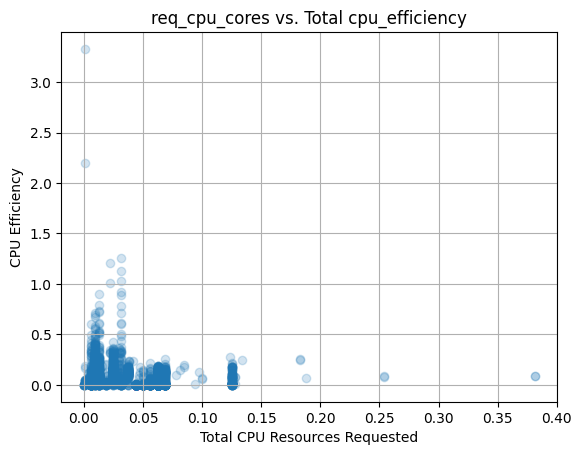

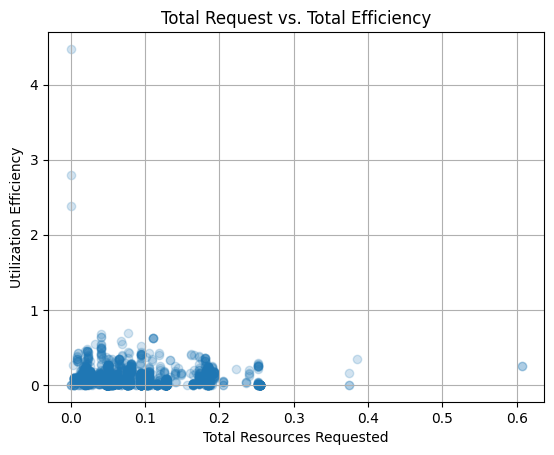

In [80]:
import matplotlib.pyplot as plt

df_sample = df_joined.select("req_cpu_cores", "cpu_efficiency").sample(False, 0.01).toPandas()

plt.scatter(df_sample["req_cpu_cores"], df_sample["cpu_efficiency"], alpha=0.2)
plt.title("req_cpu_cores vs. Total cpu_efficiency")
plt.xlabel("Total CPU Resources Requested")
plt.ylabel("CPU Efficiency")
plt.grid(True)
plt.show()


# sample 1% of the data
df_sample = df_joined.select("total_request", "total_efficiency").sample(False, 0.01).toPandas()

plt.scatter(df_sample["total_request"], df_sample["total_efficiency"], alpha=0.2)
plt.title("Total Request vs. Total Efficiency")
plt.xlabel("Total Resources Requested")
plt.ylabel("Utilization Efficiency")
plt.grid(True)
plt.show()

From this we see that in general, tasks that require more resources don't utilize them so efficiently. When total resources requested increase, there is no imrpovement in efficiency of utilization